# Preamble

In [126]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from mpl_toolkits import mplot3d
from scipy import optimize

# Study case

<IPython.core.display.Javascript object>


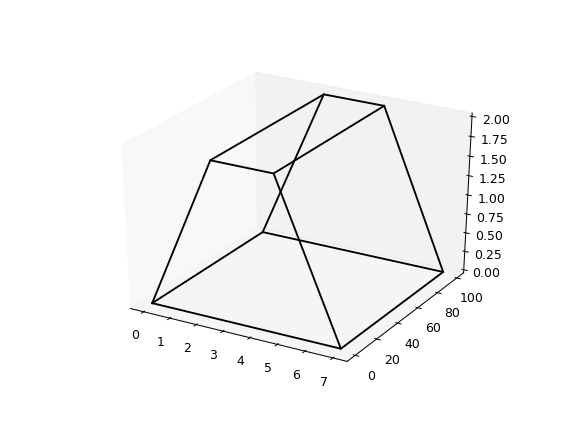

In [136]:
alpha = 40
b = 7
h = 2
l = 100
b2 = h*np.tan(np.deg2rad(90-alpha))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
def plot_pile(b,b2,h,l,c):
    ax.plot([0,b2,b-b2,b,0],[l,l,l,l,l],[0,h,h,0,0],c=c)
    ax.plot([0,b2,b-b2,b,0],[0,0,0,0,0],[0,h,h,0,0],c=c)
    ax.plot([0,0],[0,l],[0,0],c=c)
    ax.plot([b2,b2],[0,l],[h,h],c=c)
    ax.plot([b-b2,b-b2],[0,l],[h,h],c=c)
    ax.plot([b,b],[0,l],[0,0],c=c)
plot_pile(b,b2,h,l,'k')

In [128]:
def vol(alpha, b, h, l):
    b2 = h*np.tan(np.deg2rad(90-alpha))
    frontArea = h*(b+b2)/2
    totalArea = frontArea*l
    return totalArea

In [122]:
fixedVol = 10000

In [129]:
fVol = lambda l, b, h, alpha, fixedVol : vol(alpha, b, h, l)-fixedVol

In [130]:
optimize.fsolve(fVol, 0, args=(b, h, alpha, fixedVol))

array([1065.69961557])

In [165]:
alphaL = np.linspace(1,89,10)
bL = np.linspace(1,10,10)
hL = np.linspace(1,5,10)

In [166]:
data = np.zeros((len(alphaL)*len(bL)*len(hL),2))
ite = 0
for i in range(len(alphaL)):
    for j in range(len(bL)):
        for k in range(len(hL)):
            L = optimize.fsolve(fVol, 0, args=(bL[j], hL[k], alphaL[i], fixedVol))
            b2 = hL[k]*np.tan(np.deg2rad(90-alphaL[i]))
            side = np.sqrt(b2**2+hL[k]**2)
            data[ite, 0] = bL[j]*L
            data[ite, 1] = 2*(hL[k]*(bL[j]+b2)/2+side*L)+b2*L
            ite += 1

<IPython.core.display.Javascript object>


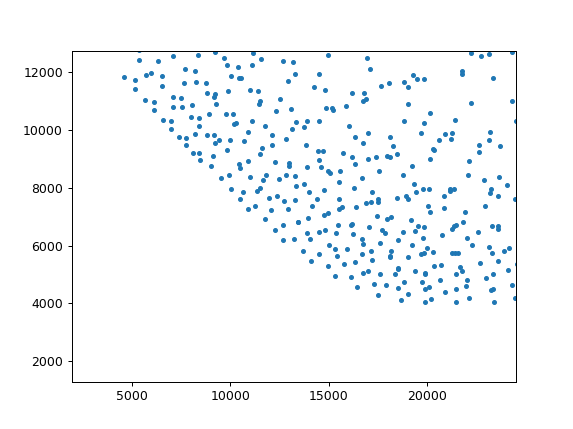

In [176]:
fig, ax = plt.subplots()
plt.plot(4*data[:,0]+data[:,1].min(),data[:,1],'.')

In [180]:
dataSum = 4*data[:,0]+data[:,1].min()+data[:,1]

In [181]:
data[dataSum.argmin(),:]

array([  146.70144719, 11834.61363325])

<IPython.core.display.Javascript object>


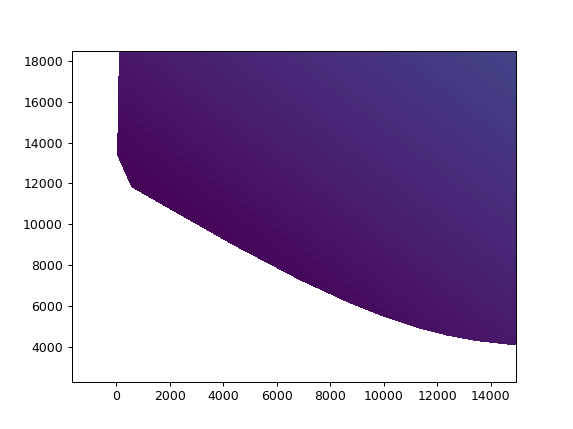

In [185]:
fig, ax = plt.subplots()
plt.tricontourf(4*data[:,0],data[:,1],dataSum,levels=200)

In [ ]:
t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())